In [1]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import *
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from DL_utils import *

In [8]:
#Example use
    
# after executing preprocessing_utils.py with 4Students_AnXplore03 in the same directory
# a folder named "data_cleaned" will be created with the preprocessed mesh files
# the function get_X_y can be used to get the input and output data of mesh_id
features_method = get_X_y_acc_type
#retrieve the list of all the mesh_ids
CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]
mesh_id = mesh_ids[0]

X_nodes, X_edges, y = features_method(mesh_id, time_step=1, )

nb_features = X_nodes.shape[1]      
print(X_nodes.shape)
print(X_edges.shape)
print(y.shape)
print(nb_features)

torch.Size([12567, 12])
torch.Size([2, 79366])
torch.Size([12567, 4])
12


/Users/leonard/Desktop/MINES/3A/IDSC/DC_flood/preprocessing_utils.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_dir / f"mesh_{mesh_id}.pth")


## data explo

In [3]:
mesh_id = mesh_ids[0]
data = torch.load(data_path / f"mesh_{mesh_id}.pth")
X_nodes_all, X_edges = data["nodes"], data["edges"]

/var/folders/m7/fyj040hx1x1fw7ttkzlnffgr0000gn/T/ipykernel_89131/1232847321.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path / f"mesh_{mesh_id

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class CFDGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CFDGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weights = None):
        x_0 = x[:,3:]
        x = self.conv1(x, edge_index, edge_weights)
        x = F.sigmoid(x)
        x = self.conv2(x, edge_index, edge_weights) 
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.lin(x) 
        return  x



In [17]:
from DL_utils import train_test_sets

# Initialisation du modèle et de l'optimiseur
model = CFDGNN(in_channels=nb_features, hidden_channels=16, out_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split des données en ensembles d'entraînement et de test
train_mesh_ids, test_mesh_ids = train_test_sets(mesh_ids, test_size=0.2, random_state=42)

# # Entraînement du modèle
# train_loss = train_model(model, optimizer, train_mesh_ids, epochs=1, batch_size=1, features_method=features_method)

# # Évaluation du modèle

average_loss = evaluate_model(model, test_mesh_ids, features_method=features_method)

print(f'Average Test Loss: {average_loss:.4f}')

Average Test Loss: 1160602.9702


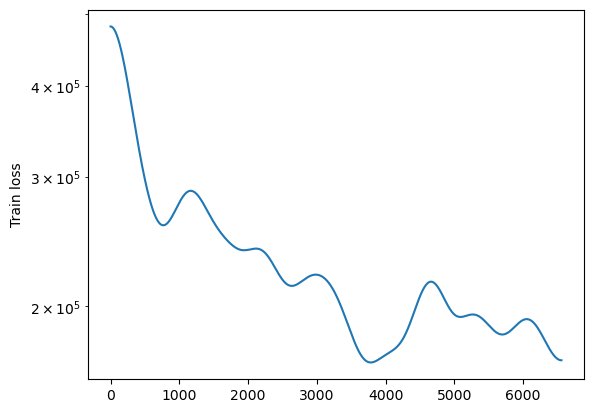

In [14]:
from scipy.ndimage import gaussian_filter1d
train_loss = gaussian_filter1d(train_loss, sigma=100)
plt.plot(train_loss)
plt.ylabel("Train loss")

plt.yscale('log')

(0.0, 10000000.0)

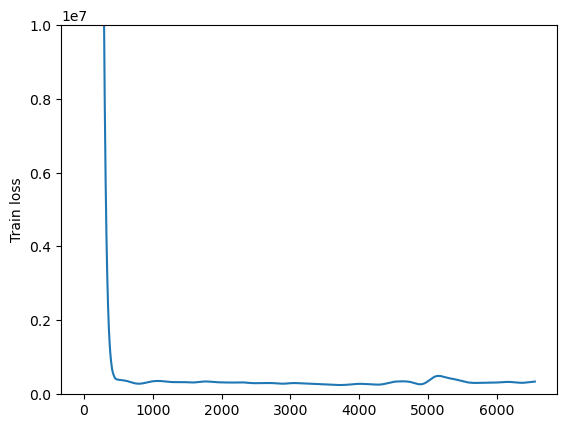

In [ ]:
from scipy.ndimage import gaussian_filter1d
train_loss = gaussian_filter1d(train_loss, sigma=100)
plt.plot(train_loss)
plt.ylabel("Train loss")
plt.ylim(0,10e6)



/Users/leonard/Desktop/MINES/3A/IDSC/DC_flood/preprocessing_utils.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_dir / f"mesh_{mesh_id}.pth")


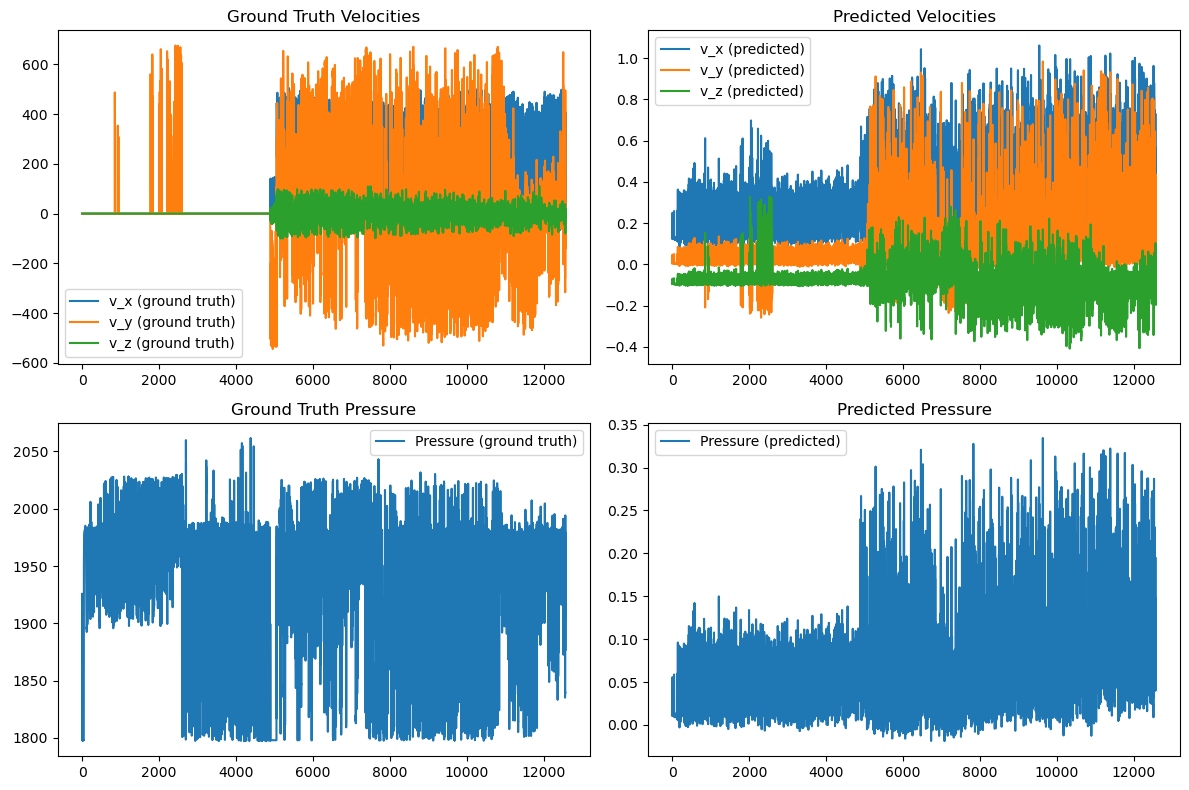

In [22]:
import random

import matplotlib.pyplot as plt

def visualize_prediction(model, mesh_id, time_step):
    X_nodes, X_edges, y = features_method(mesh_id, time_step=time_step)
    edge_weights = compute_edge_weights(X_edges, X_nodes)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_nodes, X_edges, edge_weights)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # Ground truth velocities
    axs[0, 0].plot(y[:, 0], label='v_x (ground truth)')
    axs[0, 0].plot(y[:, 1], label='v_y (ground truth)')
    axs[0, 0].plot(y[:, 2], label='v_z (ground truth)')
    axs[0, 0].set_title('Ground Truth Velocities')
    axs[0, 0].legend()
    
    # Predicted velocities
    axs[0, 1].plot(y_pred[:, 0], label='v_x (predicted)')
    axs[0, 1].plot(y_pred[:, 1], label='v_y (predicted)')
    axs[0, 1].plot(y_pred[:, 2], label='v_z (predicted)')
    axs[0, 1].set_title('Predicted Velocities')
    axs[0, 1].legend()
    
    # Ground truth pressure
    axs[1, 0].plot(y[:, 3], label='Pressure (ground truth)')
    axs[1, 0].set_title('Ground Truth Pressure')
    axs[1, 0].legend()
    
    # Predicted pressure
    axs[1, 1].plot(y_pred[:, 3], label='Pressure (predicted)')
    axs[1, 1].set_title('Predicted Pressure')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

mesh_id = mesh_ids[0]
time_step =  2
visualize_prediction(model, mesh_id, time_step)